[info] total samples: 67397
[sample] chosen_types: [67, 84, 5, 26, 73, 36, 28, 9]
[sample] subset size: 512 (expected: 512 )


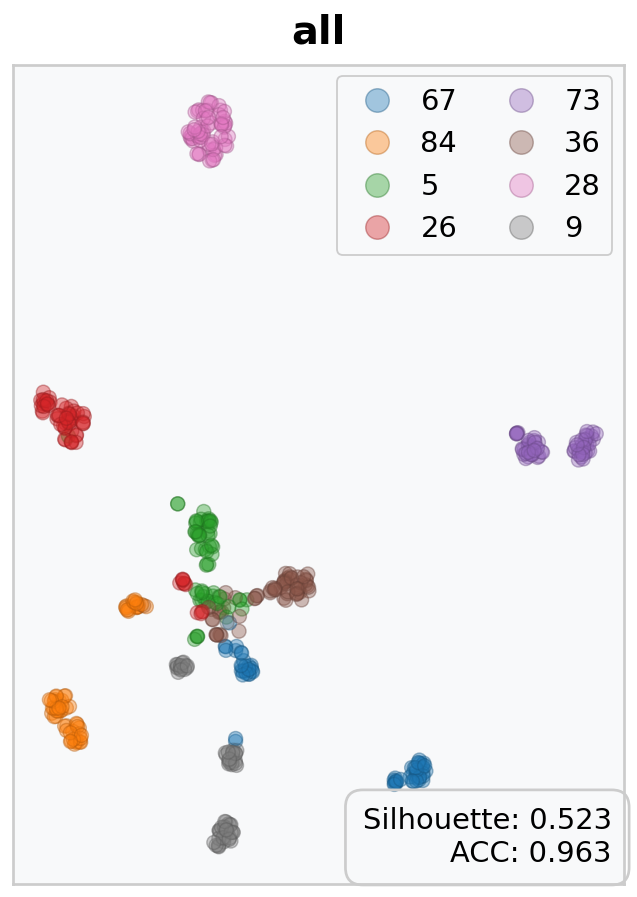

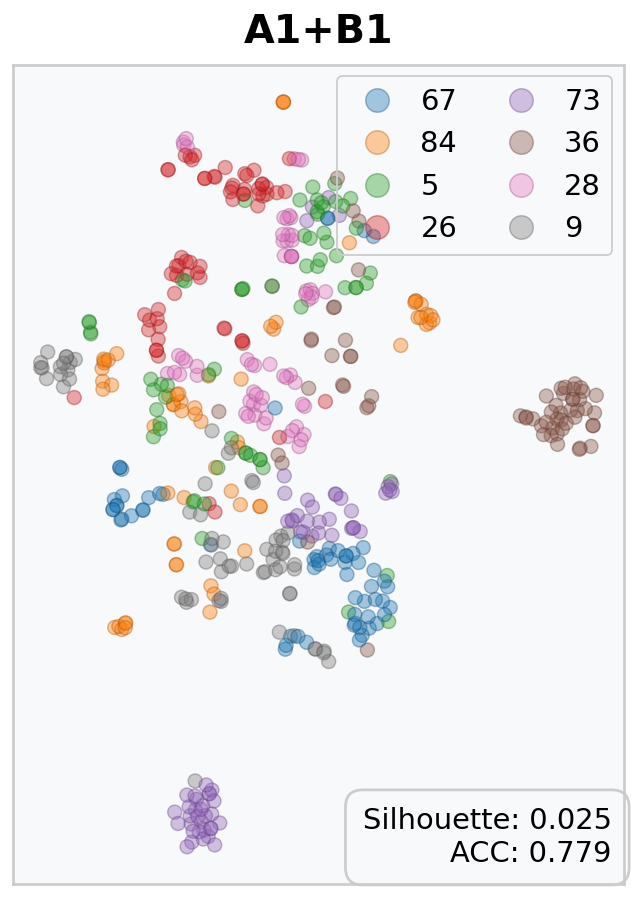

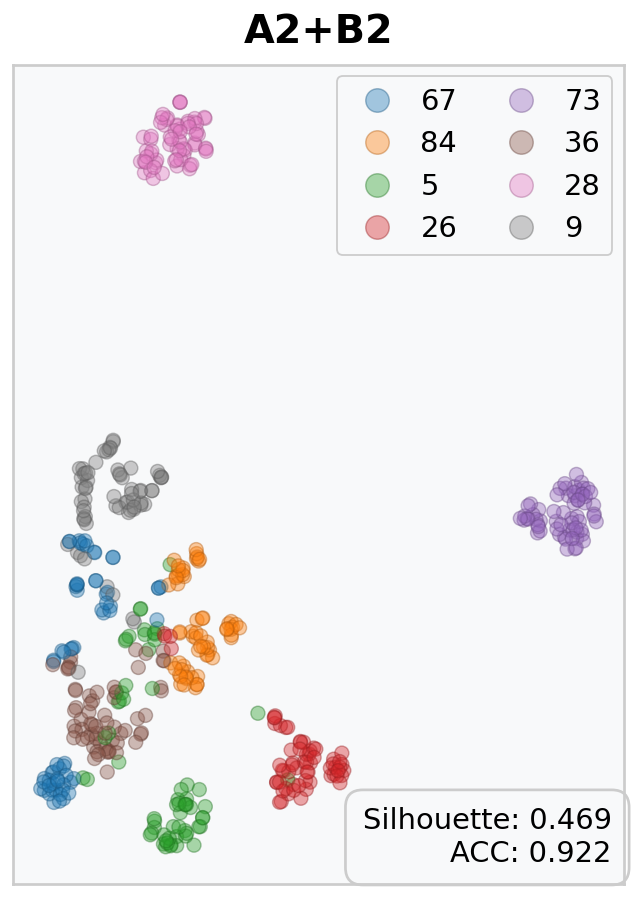

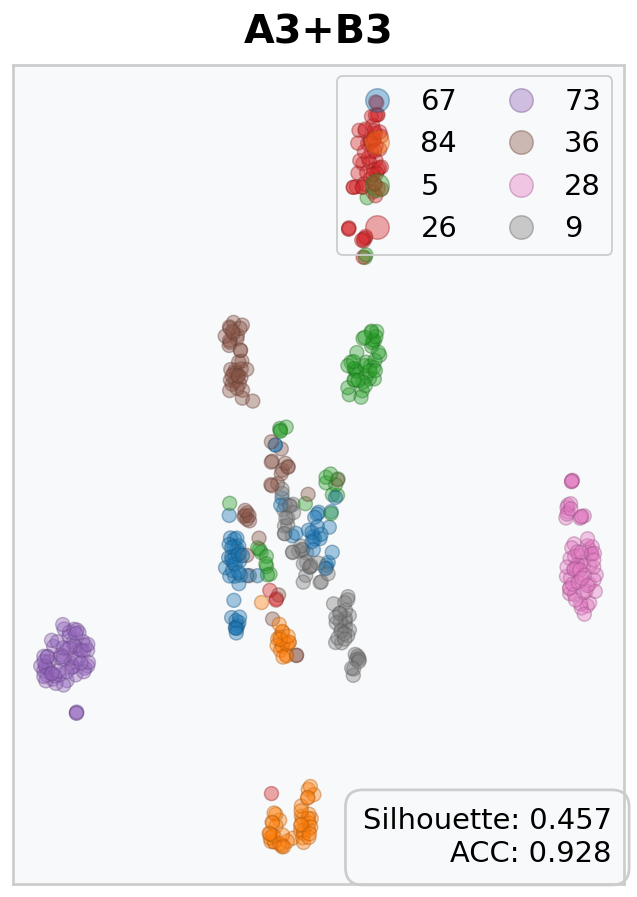

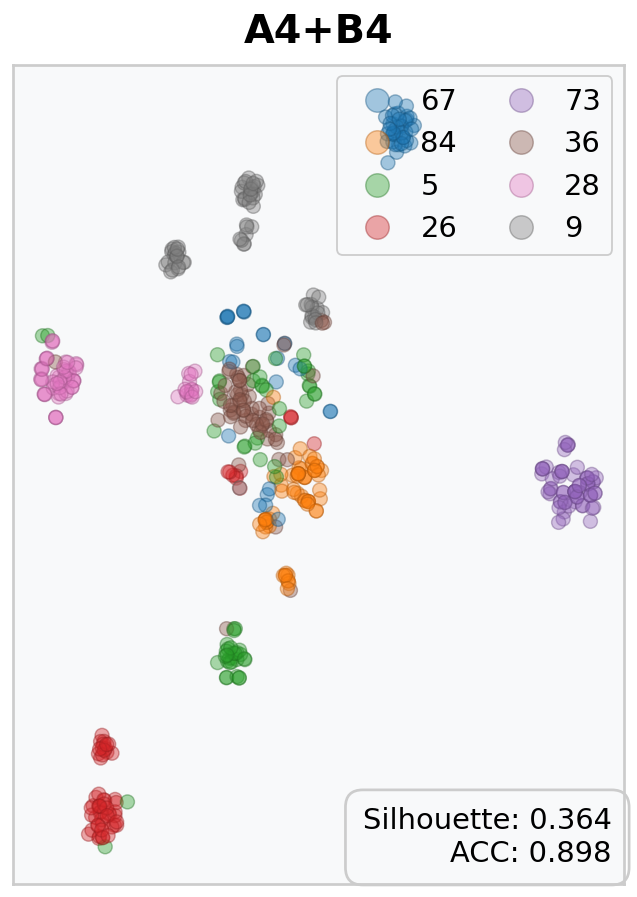

In [2]:
# =========================
# EmerGNN-style t-SNE visualization (8 types × 64 pairs)
# Manual control which modality / combination to plot
# WITH clustering quality metrics + KNN ACC in bottom-right corner
# WITH BEAUTIFIED scatter points (v6 visual style)
# V10: INCREASED FONT SIZES for title, metrics, and legend
# Requires:
#   embeddings: dict with keys "A1"... "B4", "all", "labels"
# =========================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import torch

n_drug=1710
v_id=50
save_path=f'../../result/{n_drug}/task2_embedding_v{v_id}.pt'
embeddings=torch.load(save_path)

# ---------- utils ----------
def to_numpy(x):
    """Convert torch.Tensor or numpy-like to np.ndarray."""
    if hasattr(x, "detach"):
        x = x.detach().cpu().numpy()
    return np.asarray(x)

def get_distinct_colors(k: int) -> np.ndarray:
    """Get distinct, vibrant colors for better visualization."""
    # 使用更鲜艳的配色方案
    if k <= 10:
        # 精心挑选的10种鲜艳颜色
        colors = np.array([
            [0.12, 0.47, 0.71],  # 蓝色
            [1.00, 0.50, 0.05],  # 橙色
            [0.17, 0.63, 0.17],  # 绿色
            [0.84, 0.15, 0.16],  # 红色
            [0.58, 0.40, 0.74],  # 紫色
            [0.55, 0.34, 0.29],  # 棕色
            [0.89, 0.47, 0.76],  # 粉色
            [0.50, 0.50, 0.50],  # 灰色
            [0.74, 0.74, 0.13],  # 黄绿色
            [0.09, 0.75, 0.81],  # 青色
        ], dtype=float)
        return colors[:k]
    else:
        cmap = plt.get_cmap("tab20")
        return np.array([cmap(i % 20)[:3] for i in range(k)], dtype=float)

def sample_types_and_pairs(y, n_types=8, n_per_type=64, seed=42, require_min_count=True):
    """
    Paper-style sampling:
      - randomly pick n_types interaction types
      - for each type randomly sample n_per_type pairs
    """
    rng = np.random.RandomState(seed)
    y = to_numpy(y)
    uniq = np.unique(y)

    # Prefer types with enough samples
    eligible = [lab for lab in uniq if np.sum(y == lab) >= n_per_type]
    if require_min_count and len(eligible) < n_types:
        print(f"[WARN] Eligible types (>= {n_per_type}) = {len(eligible)} < {n_types}. "
              f"Will allow replacement sampling for small types.")
        eligible = uniq.tolist()

    chosen = rng.choice(eligible, size=min(n_types, len(eligible)), replace=False)

    idx_all = []
    for lab in chosen:
        idx = np.where(y == lab)[0]
        if idx.size >= n_per_type:
            pick = rng.choice(idx, size=n_per_type, replace=False)
        else:
            pick = rng.choice(idx, size=n_per_type, replace=True)  # pad by replacement
        idx_all.append(pick)

    subset_idx = np.concatenate(idx_all)
    rng.shuffle(subset_idx)
    return chosen.tolist(), subset_idx

def tsne_2d(X_sub: np.ndarray, seed=42, pca_dim=50, perplexity=30.0):
    X_sub = StandardScaler().fit_transform(X_sub)
    """PCA (optional) -> t-SNE to 2D."""
    pca_dim = int(min(pca_dim, X_sub.shape[1]))
    if pca_dim < X_sub.shape[1]:
        X_sub = PCA(n_components=pca_dim, random_state=seed).fit_transform(X_sub)

    tsne = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=perplexity,
    early_exaggeration=12.0,
    max_iter=3000,
    random_state=seed,
    )
    return tsne.fit_transform(X_sub)

def compute_clustering_metrics(vis_2d, y_sub, n_neighbors=5, cv=5):
    """Compute silhouette score, Davies-Bouldin index, and KNN cross-validation ACC."""
    try:
        sil_score = silhouette_score(vis_2d, y_sub)
    except:
        sil_score = np.nan
    
    try:
        db_score = davies_bouldin_score(vis_2d, y_sub)
    except:
        db_score = np.nan
    
    # KNN classification with cross-validation
    try:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        # Use cross-validation to get a more robust accuracy estimate
        cv_scores = cross_val_score(knn, vis_2d, y_sub, cv=cv, scoring='accuracy')
        knn_acc = cv_scores.mean()
    except:
        knn_acc = np.nan
    
    return sil_score, db_score, knn_acc

def plot_tsne(vis_2d, y_sub, chosen_types, title, point_size=18, alpha=0.75):
    """Scatter with color by interaction type, legend shows real type ids.
    Adds clustering metrics (including KNN ACC) in bottom-right corner.
    BEAUTIFIED version with edge colors and better styling.
    V10: INCREASED FONT SIZES for all text elements."""
    chosen_types = list(chosen_types)
    type_to_id = {t: i for i, t in enumerate(chosen_types)}
    color_ids = np.array([type_to_id[t] for t in y_sub], dtype=int)

    palette = get_distinct_colors(len(chosen_types))
    colors = palette[color_ids]
    
    # 为每个点创建边缘颜色（稍微深一点）
    edge_colors = colors * 0.7  # 边缘颜色更深

    plt.figure(figsize=(5.0, 7.0), dpi=130)
    ax = plt.gca()
    
    # 设置背景色为浅灰色，更柔和
    ax.set_facecolor('#f8f9fa')
    
    # 绘制散点，添加边缘
    ax.scatter(vis_2d[:, 0], vis_2d[:, 1], 
               c=colors, 
               s=point_size, 
               alpha=alpha,
               edgecolors=edge_colors,  # 添加边缘颜色
               linewidths=0.8)  # 边缘宽度
    
    # V10: Increased title font size from 14 to 22
    ax.set_title(title, fontsize=22, fontweight='bold', pad=12)
    ax.set_xticks([]); ax.set_yticks([])
    
    # 添加边框
    for spine in ax.spines.values():
        spine.set_edgecolor('#cccccc')
        spine.set_linewidth(1.5)
    
    # Compute and display clustering metrics (including KNN ACC)
    sil_score, db_score, knn_acc = compute_clustering_metrics(vis_2d, y_sub)
    
    # V10: Increased metrics text font size from 10 to 16
    metrics_text = f"Silhouette: {sil_score:.3f}\nACC: {knn_acc:.3f}"
    ax.text(0.98, 0.02, metrics_text,
            transform=ax.transAxes,
            fontsize=16,  # Increased from 10
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.6',  # Slightly larger padding
                     facecolor='none',  # 透明背景
                     edgecolor='#cccccc',
                     alpha=1.0,
                     linewidth=1.5))
    
    plt.tight_layout()

    # V10: Increased legend font size and marker size
    handles, labels_txt = [], []
    for t in chosen_types:
        cid = type_to_id[t]
        handles.append(Line2D([0], [0], 
                              marker="o", 
                              linestyle="",
                              markerfacecolor=tuple(palette[cid]),
                              markeredgecolor=tuple(palette[cid] * 0.7),  # 边缘颜色
                              markeredgewidth=0.8,
                              markersize=13,  # Increased from 9
                              alpha=alpha))
        labels_txt.append(str(t))
    
    ax.legend(
        handles, labels_txt,
        loc="upper right",
        ncol=2,
        frameon=True,
        columnspacing=1.2,  # Slightly increased
        handletextpad=0.5,  # Slightly increased
        borderaxespad=0.4,  # Slightly increased
        fontsize=16,  # Increased from 11
        fancybox=True,  # 圆角边框
        shadow=False,
        framealpha=1.0,  # 不透明边框
        edgecolor='#cccccc',  # 保留边框
        facecolor='none'  # 透明背景
    )

def get_X_from_embeddings(embeddings: dict, key: str) -> np.ndarray:
    if key not in embeddings:
        raise KeyError(f"Key '{key}' not in embeddings. Available keys: {list(embeddings.keys())}")
    return to_numpy(embeddings[key])

# =========================
# Step 1) FIXED sampling (run once)
# =========================
# You must have `embeddings` dict in scope.
y = get_X_from_embeddings(embeddings, "labels")

N = y.shape[0]
print("[info] total samples:", N)

N_TYPES = 8
N_PER_TYPE = 64
SEED = 4

chosen_types, subset_idx = sample_types_and_pairs(
    y, n_types=N_TYPES, n_per_type=N_PER_TYPE, seed=SEED, require_min_count=True
)
y_sub = y[subset_idx]

print("[sample] chosen_types:", chosen_types)
print("[sample] subset size:", len(subset_idx), "(expected:", N_TYPES * N_PER_TYPE, ")")

# =========================
# Step 2) MANUAL plotting APIs
# =========================
def plot_one(key: str, seed=SEED, pca_dim=50, perplexity=30.0, point_size=18, alpha=0.4):
    """
    Plot a single modality embedding by key, using fixed subset_idx.
    Example: plot_one("A1")
    """
    X = get_X_from_embeddings(embeddings, key)
    X_sub = X[subset_idx]
    vis_2d = tsne_2d(X_sub, seed=seed, pca_dim=pca_dim, perplexity=perplexity)
    title=f"{key}"
    plot_tsne(
        vis_2d, y_sub, chosen_types,
        title=title,
        point_size=point_size, alpha=alpha
    )
    plt.savefig(f"figures/{title}_tsne.png", dpi=300, bbox_inches="tight")
    plt.show()

def plot_concat(keys, seed=SEED, pca_dim=50, perplexity=30.0, point_size=18, alpha=0.4):
    """
    Plot concatenation of multiple modalities along feature dimension.
    Example: plot_concat(["A1","B1"])
    """
    Xs = []
    for k in keys:
        X = get_X_from_embeddings(embeddings, k)
        Xs.append(X[subset_idx])
    X_sub = np.concatenate(Xs, axis=1)
    title=f"{'+'.join(keys)}"
    vis_2d = tsne_2d(X_sub, seed=seed, pca_dim=pca_dim, perplexity=perplexity)
    plot_tsne(
        vis_2d, y_sub, chosen_types,
        title=title,
        point_size=point_size, alpha=alpha
    )
    plt.savefig(f"figures/{title}_tsne.png", dpi=300, bbox_inches="tight")
    plt.show()

# =========================
# Examples (uncomment to run)
# =========================
# plot_one("A1")
# plot_one("B4", perplexity=20)
# plot_one("all", pca_dim=32)
#
# plot_concat(["A1", "B1"])
# plot_concat(["A1", "A2", "A3", "A4"])
# plot_concat(["B1", "B2", "B3", "B4"])
# plot_concat(["A4", "B4", "all"])


p_s=60
plot_one("all", pca_dim=12, perplexity=30.0, point_size=p_s)
plot_concat(["A1", "B1"], pca_dim=12, perplexity=30.0, point_size=p_s)
plot_concat(["A2", "B2"], pca_dim=12, perplexity=30.0, point_size=p_s)
plot_concat(["A3", "B3"], pca_dim=12, perplexity=30.0, point_size=p_s)
plot_concat(["A4", "B4"], pca_dim=12, perplexity=30.0, point_size=p_s)
